# Style Transfer using Tensorflow

by [Suvhradip Ghosh](https//www.github.com/suvhradipghosh07)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

Paper: <a href="https://arxiv.org/pdf/1903.09760.pdf">Photorealistic Style Transfer via Wavelet Transforms</a>

## Introduction:

We all have used apps like Prisma and Lucid, but have you wondered how these things works? Like we upload a photo from our camera roll and select a design to mix both the images and we get a new image which has the content of our input image and style of the design image. In the world of deep learning this is called style transfer.

Style transfer is the technique of recomposing images in the style of other images. It all started when Gatys et al. published an awesome paper on how it was actually possible to transfer artistic style from one painting to another picture using convolutional neural networks

### Example:

<img src="images/demo.jpeg">

## Flowchart 

This flowchart shows roughly the idea of the Style Transfer algorithm, although we use the VGG-16 model which has many more layers than shown here.

Two images are input to the neural network: A content-image and a style-image. We wish to generate the mixed-image which has the contours of the content-image and the colours and texture of the style-image. We do this by creating several loss-functions that can be optimized.

The loss-function for the content-image tries to minimize the difference between the features that are activated for the content-image and for the mixed-image, at one or more layers in the network. This causes the contours of the mixed-image to resemble those of the content-image.

The loss-function for the style-image is slightly more complicated, because it instead tries to minimize the difference between the so-called Gram-matrices for the style-image and the mixed-image. This is done at one or more layers in the network. The Gram-matrix measures which features are activated simultaneously in a given layer. Changing the mixed-image so that it mimics the activation patterns of the style-image causes the colour and texture to be transferred.

We use TensorFlow to automatically derive the gradient for these loss-functions. The gradient is then used to update the mixed-image. This procedure is repeated a number of times until we are satisfied with the resulting image.

There are some details of the Style Transfer algorithm not shown in this flowchart, e.g. regarding calculation of the Gram-matrices, calculation and storage of intermediate values for efficiency, a loss-function for denoising the mixed-image, and normalization of the loss-functions so they are easier to scale relative to each other.

<img src="images/15_style_transfer_flowchart.png">

# VGG Network:

<img src="images/vgg16.png">
<br>
All winning architectures of ImageNet Large Scale Visual Recognition Challenge in recent years have been some form of convolutional neural network — with the most recent winners even being able to surpass human level performance!

In 2014, the winner of the ImageNet challenge was a network created by Visual Geometry Group (VGG) at Oxford University, achieving a classification error rate of only 7.0%. Gatys et. al use this network — which has been trained to be extremely effective at object recognition — as a basis for trying to extract content and style representations from images.


## Imports

In [1]:
# importing the library
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

In [2]:
#printing tf version
print(tf.__version__)

1.13.1


<b>WARNING: It is 550 MB!</b>

In [18]:
#importing vgg16 module
#downloading the data for the VGG-16 model
import vgg16
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Define a function for Image Manupulation

In [3]:
def get_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)


### Save an image as a jpeg-file. The image is given as a numpy array with pixel-values between 0 and 255.

In [4]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')


In [5]:

def plot_imagebig(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [6]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smoother = True
    
    # Interpolation type.
    if smoother:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## Loss Functions

In [7]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. When this content-loss is minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers you select, this should transfer the contours from the content-image to the mixed-image.

In [8]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [9]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

In [10]:
def create_style_loss(session, model, style_image, layer_ids):

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [11]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

# Style-Transfer Algorithm

This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.


In [20]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    
    
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_imagebig(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [21]:
content_filename = 'images/demo2.jpg'
content_image = get_image(content_filename, max_size=None)


In [22]:
style_filename = 'images/style.png'
style_image = get_image(style_filename, max_size=300)


In [23]:
content_layer_ids = [4]

In [24]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.09e-10, Style: 3.34e-28, Denoise: 5.57e-06


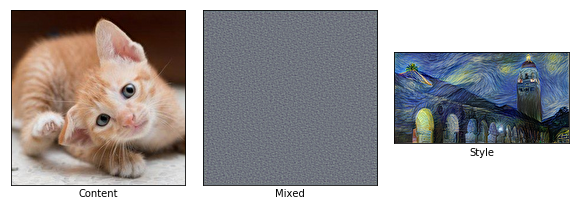

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.20e-10, Style: 6.06e-27, Denoise: 2.38e-07


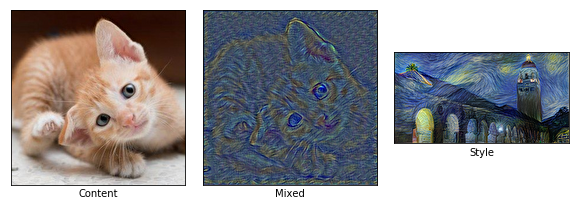

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.25e-10, Style: 1.02e-26, Denoise: 2.38e-07


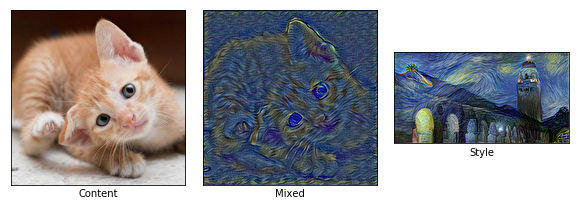

. . . . . . . . . 
Iteration: 29
Weight Adj. for Content: 9.38e-11, Style: 2.25e-27, Denoise: 1.64e-07


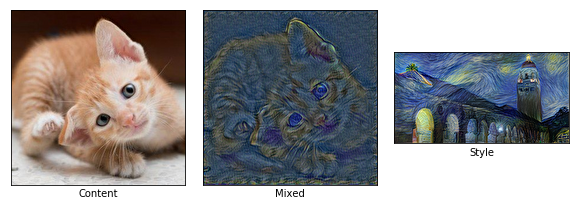


Final image:


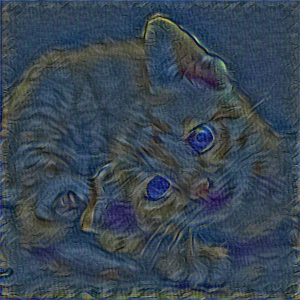

CPU times: user 3min 40s, sys: 9.52 s, total: 3min 50s
Wall time: 2min 21s


In [25]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=30,
                     step_size=10.0)